### Binary Classification Model for LendingClub Loan Data Using Python and XGBoost
### David Lowe
### August 11, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle LendingClub Loan Data dataset is a binary classification situation where we attempt to predict one of the two possible outcomes.

INTRODUCTION: The Kaggle dataset owner derived this dataset from the publicly available data of LendingClub.com. Lending Club connects people who need money (borrowers) with people who have money (investors). An investor naturally would want to invest in people who showed a profile of having a high probability of paying back the loan. The dataset uses the lending data from 2007 to 2010, and we will try to predict whether the borrower paid back their loan in full.

ANALYSIS: The performance of the preliminary XGBoost model achieved a ROC-AUC benchmark of 0.8103. After a series of tuning trials, the refined XGBoost model processed the training dataset with a final ROC-AUC score of 0.8491. When we applied the last model to Kaggle's test dataset, the model achieved a ROC-AUC score of 0.6039.

CONCLUSION: In this iteration, the XGBoost model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Kaggle LendingClub Loan Data

Dataset ML Model: Binary classification with numerical and categorical attributes

Dataset Reference: https://www.kaggle.com/itssuru/loan-data

One potential source of performance benchmark: https://www.kaggle.com/itssuru/loan-data/code

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Fine-tune and Improve Models
6. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Retrieve the GPU information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Mon Aug  9 23:41:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve the memory configuration from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


### 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
RNG_SEED = 8

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline as SKL_Pipeline
from sklearn import compose
from sklearn import impute
from imblearn.pipeline import Pipeline as IMB_Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
# VAL_SET_RATIO = 0.25
TEST_SET_RATIO = 0.1

# Set the number of folds for cross validation
N_FOLDS = 10

# Set various default modeling parameters
SCORING_METRIC = 'roc_auc'

In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [10]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-lendingclub-loan-data/loan_data.csv'
df_dataset_import = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   credit.policy             purpose  ...  pub.rec  not.fully.paid
0              1  debt_consolidation  ...        0               0
1              1         credit_card  ...        0               0
2              1  debt_consolidation  ...        0               0
3              1  debt_consolidation  ...        0               0
4              1         credit_card  ...        0               0

[5 rows x 14 columns]


In [11]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [12]:
print(df_dataset_import.describe())

       credit.policy     int.rate  ...      pub.rec  not.fully.paid
count    9578.000000  9578.000000  ...  9578.000000     9578.000000
mean        0.804970     0.122640  ...     0.062122        0.160054
std         0.396245     0.026847  ...     0.262126        0.366676
min         0.000000     0.060000  ...     0.000000        0.000000
25%         1.000000     0.103900  ...     0.000000        0.000000
50%         1.000000     0.122100  ...     0.000000        0.000000
75%         1.000000     0.140700  ...     0.000000        0.000000
max         1.000000     0.216400  ...     5.000000        1.000000

[8 rows x 13 columns]


In [13]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [14]:
# Convert columns from one data type to another
df_dataset_import['purpose'] = df_dataset_import['purpose'].astype('category')

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

   credit.policy             purpose  ...  pub.rec  not.fully.paid
0              1  debt_consolidation  ...        0               0
1              1         credit_card  ...        0               0
2              1  debt_consolidation  ...        0               0
3              1  debt_consolidation  ...        0               0
4              1         credit_card  ...        0               0

[5 rows x 14 columns]


In [15]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   credit.policy      9578 non-null   int64   
 1   purpose            9578 non-null   category
 2   int.rate           9578 non-null   float64 
 3   installment        9578 non-null   float64 
 4   log.annual.inc     9578 non-null   float64 
 5   dti                9578 non-null   float64 
 6   fico               9578 non-null   int64   
 7   days.with.cr.line  9578 non-null   float64 
 8   revol.bal          9578 non-null   int64   
 9   revol.util         9578 non-null   float64 
 10  inq.last.6mths     9578 non-null   int64   
 11  delinq.2yrs        9578 non-null   int64   
 12  pub.rec            9578 non-null   int64   
 13  not.fully.paid     9578 non-null   int64   
dtypes: category(1), float64(6), int64(7)
memory usage: 982.6 KB


In [16]:
print(df_dataset_import.describe())

       credit.policy     int.rate  ...      pub.rec  not.fully.paid
count    9578.000000  9578.000000  ...  9578.000000     9578.000000
mean        0.804970     0.122640  ...     0.062122        0.160054
std         0.396245     0.026847  ...     0.262126        0.366676
min         0.000000     0.060000  ...     0.000000        0.000000
25%         1.000000     0.103900  ...     0.000000        0.000000
50%         1.000000     0.122100  ...     0.000000        0.000000
75%         1.000000     0.140700  ...     0.000000        0.000000
max         1.000000     0.216400  ...     5.000000        1.000000

[8 rows x 13 columns]


In [17]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Sets

In [18]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

In [19]:
# Standardize the class column to the name of target
df_dataset_import = df_dataset_import.rename(columns={'not.fully.paid':'target'})

In [20]:
# Split the data further into training, validation, and test datasets
df_train, df_test = train_test_split(df_dataset_import, test_size=TEST_SET_RATIO, stratify=df_dataset_import['target'], random_state=RNG_SEED)

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
# for various visualization and cleaning/transformation operations
df_target_train = df_train['target']
df_features_train = df_train.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_train.shape: {} df_test.shape: {}".format(df_dataset_import.shape, df_train.shape,df_test.shape))
print("df_features_train.shape: {} df_target_train.shape: {}".format(df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (9578, 14) df_train.shape: (8620, 14) df_test.shape: (958, 14)
df_features_train.shape: (8620, 13) df_target_train.shape: (8620,)


### 1.f) Set up the parameters for data visualization

In [21]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [22]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [23]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

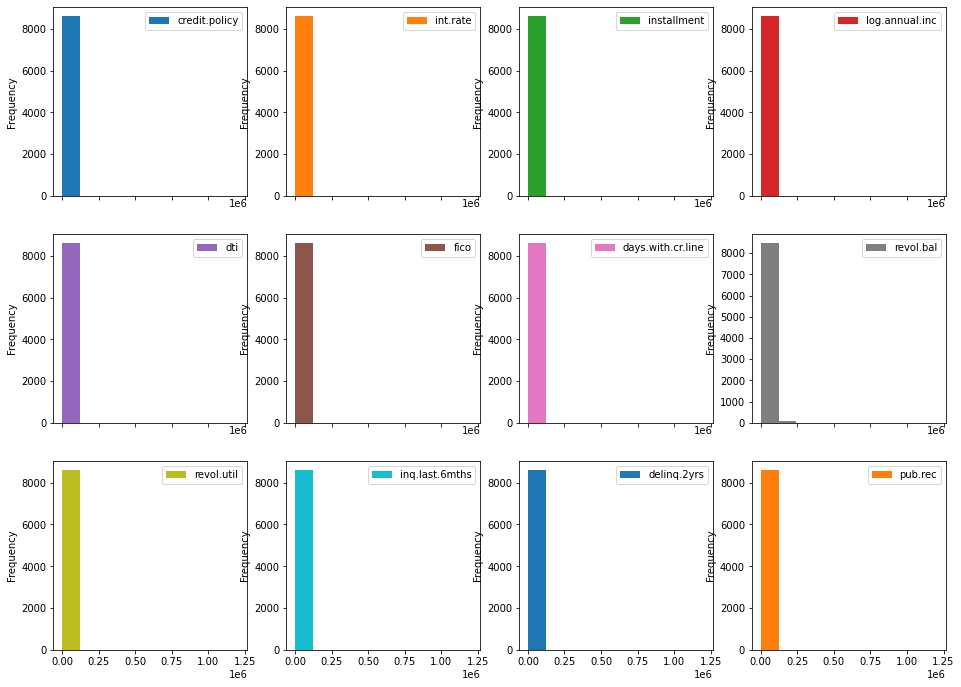

In [24]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

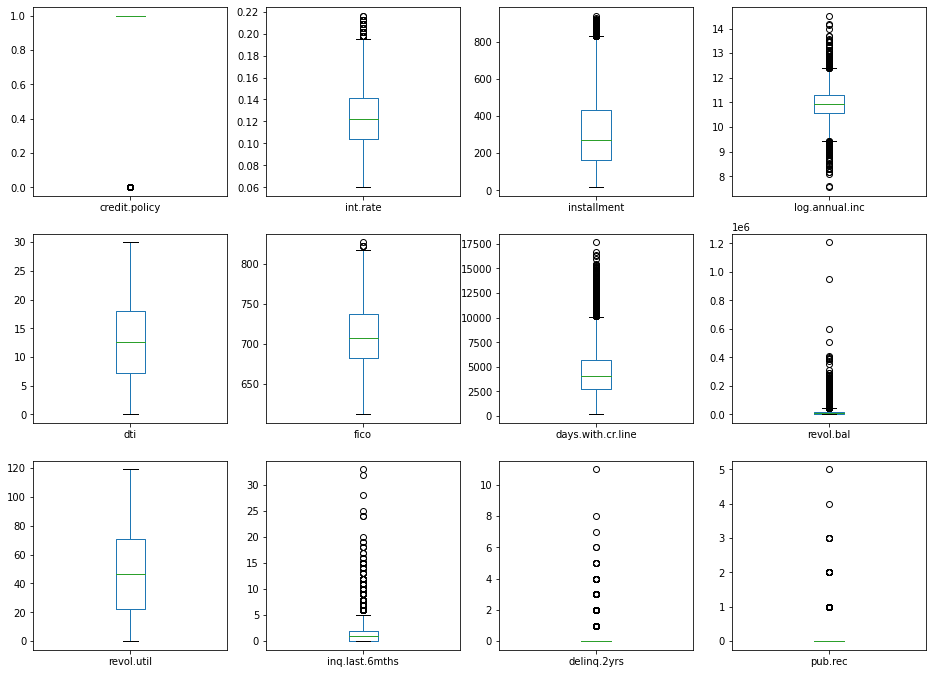

In [25]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

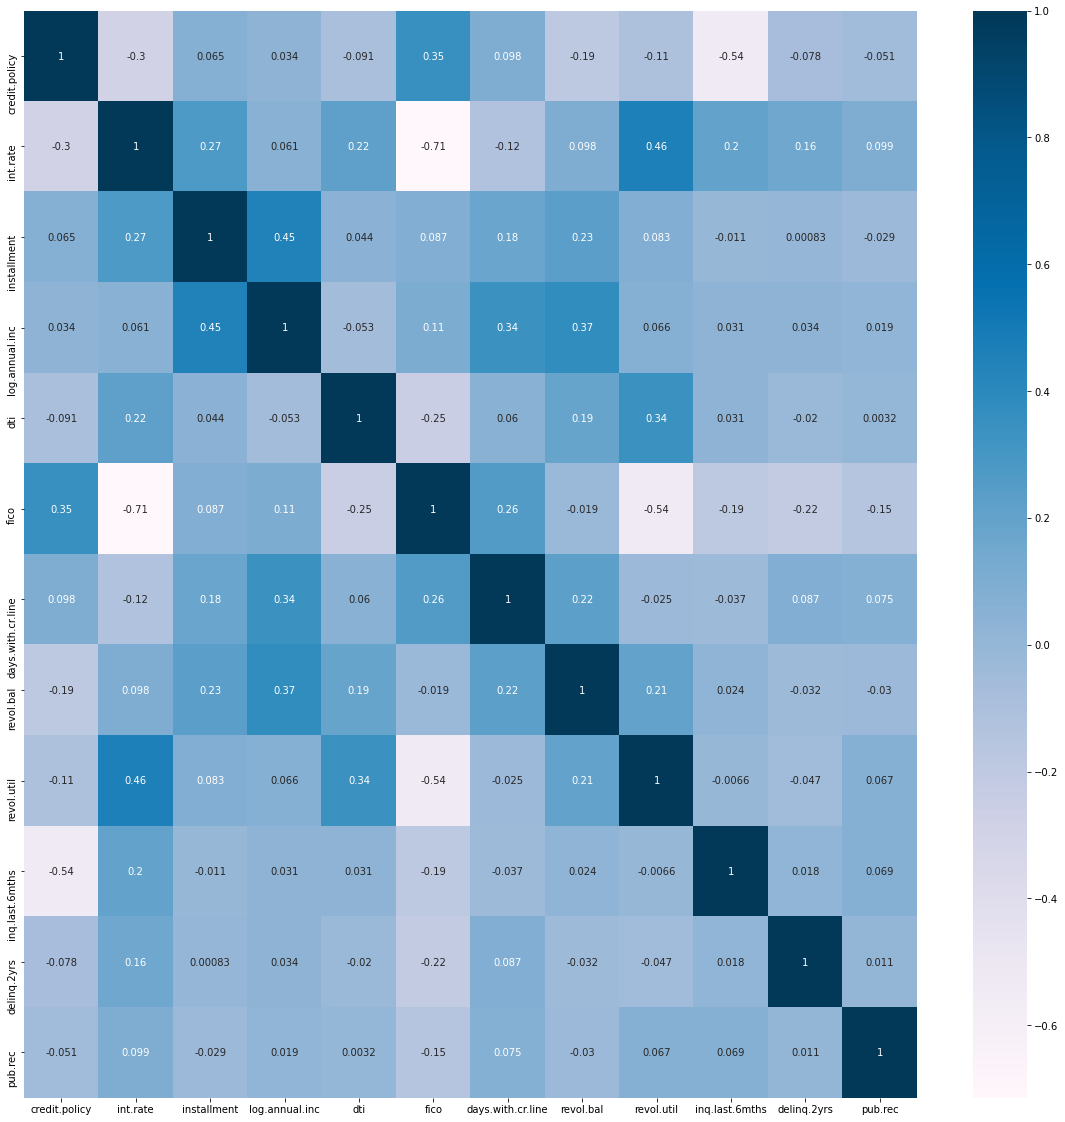

In [26]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [27]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [28]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling and Data Pre-Processing

In [29]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int64','float64']).columns
numeric_transformer = SKL_Pipeline(steps=[
#     ('imputer', impute.SimpleImputer(strategy="median")),
    ('scaler', preprocessing.MinMaxScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = SKL_Pipeline(steps=[
#     ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 12
Number of categorical columns: 1
Total number of columns in the feature dataframe: 13


In [30]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (8620, 13) to array_features_train.shape: (8620, 19)


### 3.b) Training Data Balancing

In [31]:
feature_train_imbal = array_features_train
target_train_imbal = df_target_train.values.ravel()
print("feature_train_imbal.shape: {} target_train_imbal.shape: {}".format(feature_train_imbal.shape, target_train_imbal.shape))

feature_train_imbal.shape: (8620, 19) target_train_imbal.shape: (8620,)


In [32]:
# Perform SMOTE transformation on the training data
print ('Original class distribution - 1: {} | 0: {}'.format((target_train_imbal==1).sum(), (target_train_imbal==0).sum()))
over_sample = SMOTE(sampling_strategy=0.4, random_state=RNG_SEED)
under_sample = RandomUnderSampler(sampling_strategy=1.0, random_state=RNG_SEED)
resample_pipeline = IMB_Pipeline(steps=[
    ('o', over_sample),
    ('u', under_sample)])
array_features_train, array_target_train = resample_pipeline.fit_resample(feature_train_imbal, target_train_imbal)
print ('Resampled class distribution - 1: {} | 0: {}'.format((array_target_train==1).sum(), (array_target_train==0).sum()))

Original class distribution - 1: 1380 | 0: 7240
Resampled class distribution - 1: 2896 | 0: 2896


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### 3.c) Feature Selection

In [33]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [34]:
# Finalize the training and validation datasets for the modeling activities
# array_features_train = df_features_train.to_numpy()
# array_target_train = df_target_train.ravel()
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (5792, 19) array_target_train.shape: (5792,)


In [35]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Evaluate Models

In [36]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [37]:
# Set up Algorithms Spot-Checking Array
start_time_training = datetime.now()
train_models = [('XGB', XGBClassifier(random_state=RNG_SEED, n_jobs=N_JOBS, objective='binary:logistic',
                                      eval_metric='auc', use_label_encoder=False, tree_method='gpu_hist'))]

In [38]:
# Generate model in turn
for name, model in train_models:
	if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	start_time_module = datetime.now()
	kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
	cv_results = cross_val_score(model, array_features_train, array_target_train, cv=kfold, scoring=SCORING_METRIC, n_jobs=N_JOBS, verbose=1)
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - start_time_module), '\n')
	if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


XGB: 0.810338 (0.019394)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=8,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist',
              use_label_encoder=False, verbosity=1)
Model training time: 0:00:02.648763 



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.6s finished


### 4.b) Algorithm Tuning

In [39]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [40]:
# Tuning XGBoost n_estimators, max_depth, and min_child_weight parameters
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #1 has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = XGBClassifier(random_state=RNG_SEED, n_jobs=N_JOBS, objective='binary:logistic',
                            eval_metric='auc', use_label_encoder=False, tree_method='gpu_hist')
tune_model_names.append('XGB_1')
paramGrid1 = dict(n_estimators=range(100, 501, 100),
                  max_depth=np.array([3, 6, 9]),
                  min_child_weight=np.array([1, 2, 3]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result1 = grid1.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #1 completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 45 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:  7.9min finished


Best: 0.843802 using {'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300}
0.810338 (0.019394) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
0.815149 (0.018845) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
0.816900 (0.020518) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300}
0.818488 (0.020947) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 400}
0.817146 (0.021681) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500}
0.808199 (0.020686) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100}
0.815243 (0.020944) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 200}
0.816281 (0.021783) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 300}
0.818069 (0.022577) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 400}
0.817287 (0.021560) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 500}
0.809181 (0.019982) with: {'max_depth': 3, 'min_

In [41]:
# Tuning XGBoost subsample and colsample_bytree parameters
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #2 has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = XGBClassifier(n_estimators=300, max_depth=9, min_child_weight=1,
                            random_state=RNG_SEED, n_jobs=N_JOBS, objective='binary:logistic',
                            eval_metric='auc', use_label_encoder=False, tree_method='gpu_hist')
tune_model_names.append('XGB_2')
paramGrid2 = dict(subsample=np.array([0.7, 0.8, 0.9, 1.0]), colsample_bytree=np.array([0.7, 0.8, 0.9, 1.0]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result2 = grid2.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #2 completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  5.3min finished


Best: 0.849111 using {'colsample_bytree': 0.9, 'subsample': 0.8}
0.845278 (0.018622) with: {'colsample_bytree': 0.7, 'subsample': 0.7}
0.845117 (0.019078) with: {'colsample_bytree': 0.7, 'subsample': 0.8}
0.844445 (0.018881) with: {'colsample_bytree': 0.7, 'subsample': 0.9}
0.845201 (0.016841) with: {'colsample_bytree': 0.7, 'subsample': 1.0}
0.845644 (0.019823) with: {'colsample_bytree': 0.8, 'subsample': 0.7}
0.847096 (0.017994) with: {'colsample_bytree': 0.8, 'subsample': 0.8}
0.845564 (0.018450) with: {'colsample_bytree': 0.8, 'subsample': 0.9}
0.844713 (0.018973) with: {'colsample_bytree': 0.8, 'subsample': 1.0}
0.845449 (0.018560) with: {'colsample_bytree': 0.9, 'subsample': 0.7}
0.849111 (0.019633) with: {'colsample_bytree': 0.9, 'subsample': 0.8}
0.847746 (0.018297) with: {'colsample_bytree': 0.9, 'subsample': 0.9}
0.843118 (0.019622) with: {'colsample_bytree': 0.9, 'subsample': 1.0}
0.845415 (0.019697) with: {'colsample_bytree': 1.0, 'subsample': 0.7}
0.846114 (0.019860) with:

### 4.c) Compare Algorithms After Tuning

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


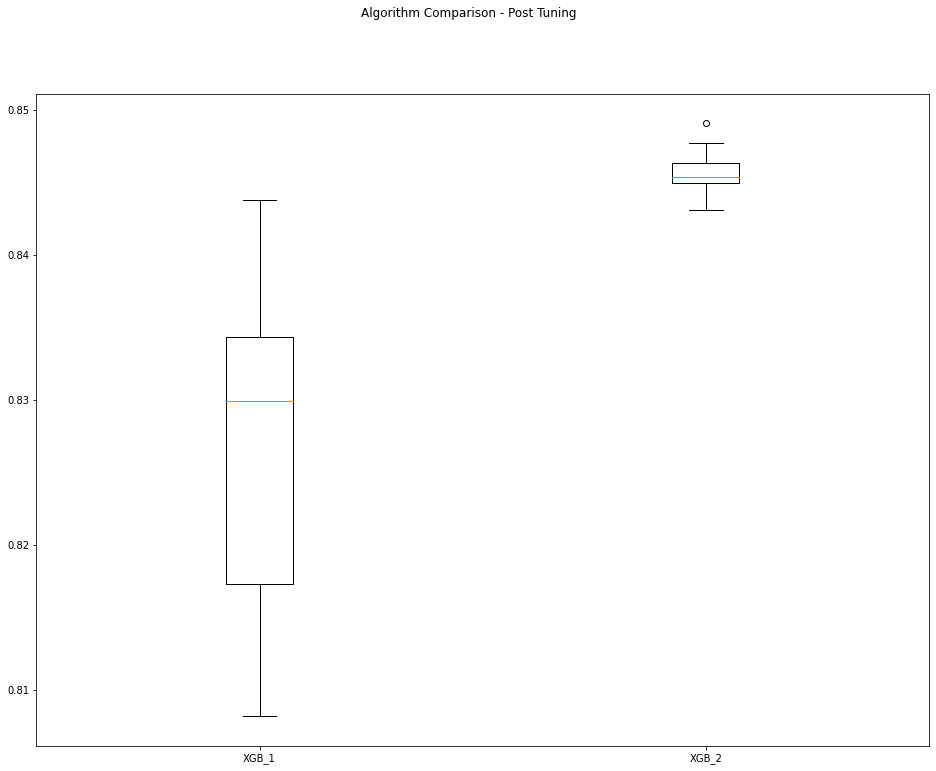

In [42]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [43]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Present Analysis

In [44]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Train the Final Model

In [45]:
final_model = XGBClassifier(n_estimators=300, max_depth=9, min_child_weight=1,
                            colsample_bytree=0.9, subsample=0.8,
                            random_state=RNG_SEED, n_jobs=N_JOBS, objective='binary:logistic',
                            eval_metric='auc', use_label_encoder=False, tree_method='gpu_hist')
final_model.fit(array_features_train, array_target_train)
print(final_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, eval_metric='auc',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=8,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, tree_method='gpu_hist',
              use_label_encoder=False, verbosity=1)


### 6.b) Load Test Dataset and Make Predictions

In [46]:
# We create attribute-only and target-only datasets
df_target_test = df_test['target']
df_features_test = df_test.drop(['target'], axis=1)

print("df_features_test.shape: {} df_target_test.shape: {}".format(df_features_test.shape, df_target_test.shape))

df_features_test.shape: (958, 13) df_target_test.shape: (958,)


In [47]:
# Finalize the test dataset for the modeling testing
array_features_test = preprocessor.transform(df_features_test)
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (958, 13) to array_features_test.shape: (958, 19)


In [48]:
# Finalize the test dataset for the testing activities
array_target_test = df_target_test.ravel()
print("array_features_test.shape: {} array_target_test.shape: {}".format(array_features_test.shape, array_target_test.shape))

array_features_test.shape: (958, 19) array_target_test.shape: (958,)


In [49]:
# Make batched predictions
test_predictions = final_model.predict(array_features_test)
print(test_predictions)

[0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0
 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0
 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 1
 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0
 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 0 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1
 0 1 0 0 0 0 0 1 0 1 0 0 

In [50]:
print('Accuracy Score:', accuracy_score(array_target_test, test_predictions))
print('ROC/AUC Score:', roc_auc_score(array_target_test, test_predictions))
print(confusion_matrix(array_target_test, test_predictions))
print(classification_report(array_target_test, test_predictions))

Accuracy Score: 0.7526096033402923
ROC/AUC Score: 0.6039905817399425
[[662 143]
 [ 94  59]]
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       805
           1       0.29      0.39      0.33       153

    accuracy                           0.75       958
   macro avg       0.58      0.60      0.59       958
weighted avg       0.78      0.75      0.77       958



In [51]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [52]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:13:26.268432
